# TP Stéréoscopie&Segmentation

## 1-Anaglyphe

In [2]:
from PIL import Image
import sys
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

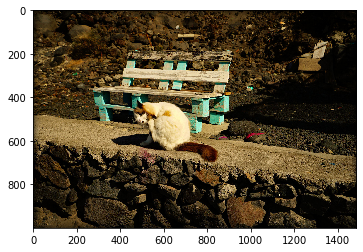

In [3]:
cat_l = Image.open("cat_l.jpg")
plt.imshow(cat_l,'gray')
plt.show()

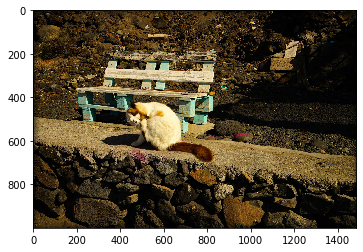

In [4]:
cat_r = Image.open("cat_r.jpg")
plt.imshow(cat_r,'gray')
plt.show()

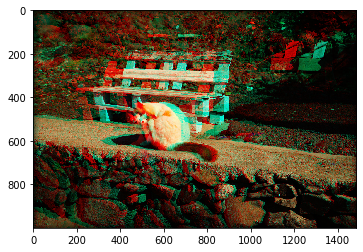

In [5]:
cat_l_Red, cat_l_Green, cat_l_Blue = cat_l.split()
cat_r_Red, cat_r_Green, cat_r_Blue = cat_r.split()
anyglyhpe = Image.merge('RGB', [cat_r_Red, cat_l_Green, cat_l_Blue])
plt.imshow(anyglyhpe,'gray')
plt.show()

## 2- Carte de disparité

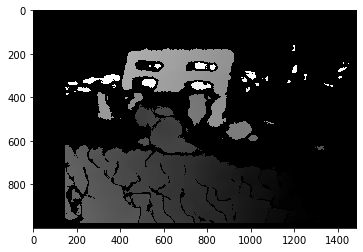

In [6]:
cat_l = cv2.imread('cat_l.jpg',0)
cat_r = cv2.imread('cat_r.jpg',0)

stereo = cv2.StereoBM_create(numDisparities=128, blockSize=45)
#stereo.setPreFilterCap(20)
disparity = stereo.compute(cat_l,cat_r)
plt.imshow(disparity,'gray')
plt.show()

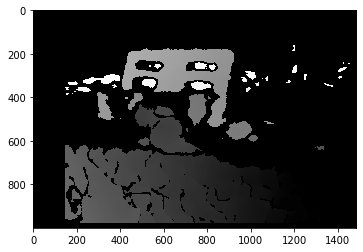

In [7]:
kernel = np.ones((3,3), np.uint8)
disparity = cv2.morphologyEx(disparity, cv2.MORPH_CLOSE, kernel,iterations = 2)
plt.imshow(disparity,'gray') 
plt.show()

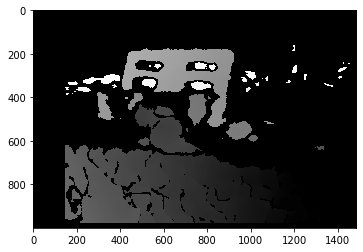

In [8]:
kernel1 = np.ones((1,1), np.uint8)
disparity = cv2.morphologyEx(disparity, cv2.MORPH_OPEN, kernel1,iterations = 1)
plt.imshow(disparity,'gray') 
plt.show()

### WATERSHED SEGEMENTATION
#### 1 - Watershed segementation image originale

In [11]:
img = cv2.imread('cat_l.jpg',1)

<function matplotlib.pyplot.show(*args, **kw)>

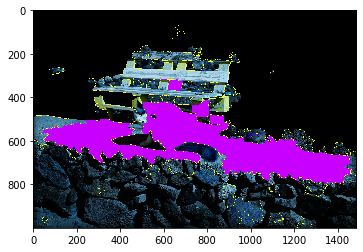

In [12]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((13,13),np.uint8)
kernel1 = np.ones((13,13),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel1, iterations = 1)
# sure background area
sure_erode = cv2.dilate(opening,kernel,iterations=5)
sure_bg = cv2.dilate(sure_erode,kernel1,iterations=4)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.007*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,255,0]
img[markers == 1] = [200,0,255]
img[markers == 2] = [0,0,0]
img[markers == 3] = [0,0,0]
img[markers == 4] = [0,0,0]
#cv2.imwrite('segmented.jpg',img)
plt.imshow(img)
plt.show

#### 2 - Watershed segementation image de disparitée

In [28]:
img = cv2.imread('disparity.jpg',1)


<function matplotlib.pyplot.show(*args, **kw)>

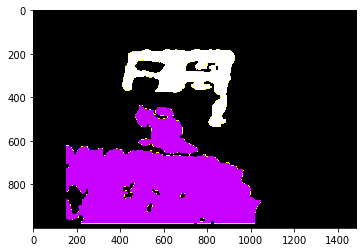

In [29]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((13,13),np.uint8)
kernel1 = np.ones((13,13),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel1, iterations = 1)
# sure background area
sure_erode = cv2.dilate(opening,kernel,iterations=5)
sure_bg = cv2.dilate(sure_erode,kernel1,iterations=4)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.007*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,255,0]
img[markers == 1] = [200,0,255]
img[markers == 2] = [0,0,0]
img[markers == 3] = [0,0,0]
img[markers == 4] = [0,0,0]
#cv2.imwrite('segmented.jpg',img)
plt.imshow(img)
plt.show


#### 3- Watershed segementation methode de gradient image originale 

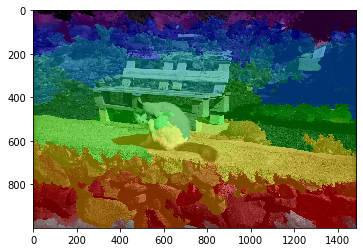

In [31]:
image = cv2.imread('cat_l.jpg',0)
# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)
plt.imshow(image, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.show()

#### 4- Watershed segementation methode de gradient image disparitée 

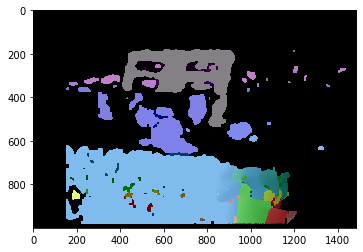

In [32]:
image = cv2.imread('disparity.jpg',0)
# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)
plt.imshow(image, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.show()